In [3]:
!pip install -q opendatasets

In [4]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/splcher/animefacedataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shsp1pshs
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:18<00:00, 22.5MB/s]


In [6]:
od.download('https://www.kaggle.com/datasets/sshikamaru/car-object-detection')
od.download('https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shsp1pshs
Your Kaggle Key: ··········


100%|██████████| 112M/112M [00:06<00:00, 18.5MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shsp1pshs
Your Kaggle Key: ··········


100%|██████████| 192M/192M [00:12<00:00, 16.4MB/s]


QUESTION-1

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import pathlib
import matplotlib.pyplot as plt
import numpy as np

import os
import PIL
import time

from IPython import display

In [8]:
rpath = '/content/animefacedataset/images'
rpath = pathlib.Path(rpath)

In [30]:
batch_size = 64

data =  keras.utils.image_dataset_from_directory(directory = rpath,
                                                 label_mode = None,
                                                 batch_size = batch_size,
                                                 image_size = (64,64))

Found 63565 files belonging to 1 classes.


In [31]:
data = data.map(lambda d : ((d-127.5)/127.5))

In [32]:
def discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(filters = 64, kernel_size = 3, strides = (2,2), padding = 'same', activation = 'LeakyReLU', input_shape = (64,64,3),))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters = 128, kernel_size = 3, strides = (2,2), padding = 'same', activation = 'LeakyReLU'))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters = 256, kernel_size = 3, strides = (2,2), padding = 'same', activation = 'LeakyReLU'))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(units = 1, activation = 'softmax'))

  return discriminator

D_mod = discriminator()
D_mod.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_16 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_17 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 128)      

In [33]:
d_optimizer = Adam(1e-4)

In [16]:
latent_dim = 100

In [34]:
def generator():
  generator = Sequential()
  generator.add(Dense(units = 4*4*256, input_shape = [latent_dim], use_bias = False,))
  generator.add(Reshape((4,4,256)))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'ReLU'))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'ReLU'))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'ReLU'))
  generator.add(BatchNormalization())


  generator.add(Conv2DTranspose(filters = 3, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'tanh'))

  return generator

G_mod = generator()
G_mod.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4096)              409600    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_19 (Ba  (None, 4, 4, 256)         1024      
 tchNormalization)                                               
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 8, 8, 128)         295040    
 Transpose)                                                      
                                                                 
 batch_normalization_20 (Ba  (None, 8, 8, 128)         512       
 tchNormalization)                                               
                                                      

In [35]:
g_optimizer = Adam(1e-4)

In [36]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):

        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(seed)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [37]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = GAN(discriminator = D_mod, generator = G_mod, latent_dim = latent_dim)
model.compile(d_optimizer = d_optimizer, g_optimizer = g_optimizer, loss_fn = loss_fn)
epochs = 15
history = model.fit(data, epochs=epochs)

Epoch 1/15
994/994 [==============================] - 65s 54ms/step - d_loss: 0.4208 - g_loss: 189.0868
Epoch 2/15
994/994 [==============================] - 52s 53ms/step - d_loss: 0.4569 - g_loss: 33.7287
Epoch 3/15
994/994 [==============================] - 53s 53ms/step - d_loss: 0.4465 - g_loss: 4.5593
Epoch 4/15
994/994 [==============================] - 53s 53ms/step - d_loss: 0.2648 - g_loss: 3.1806
Epoch 5/15
994/994 [==============================] - 52s 52ms/step - d_loss: 0.2610 - g_loss: 3.2207
Epoch 6/15
994/994 [==============================] - 53s 53ms/step - d_loss: 0.2419 - g_loss: 3.4341
Epoch 7/15
994/994 [==============================] - 53s 53ms/step - d_loss: 0.2810 - g_loss: 3.5607
Epoch 8/15
994/994 [==============================] - 53s 53ms/step - d_loss: 0.2578 - g_loss: 3.2401
Epoch 9/15
994/994 [==============================] - 52s 53ms/step - d_loss: 0.2601 - g_loss: 3.1672
Epoch 10/15
994/994 [==============================] - 53s 53ms/step - d_loss: 

In [38]:
noise = tf.random.normal([32,100])
gen_img = G_mod(noise, training=False)

In [39]:
gen_img1 = (gen_img+127.5)*127.5

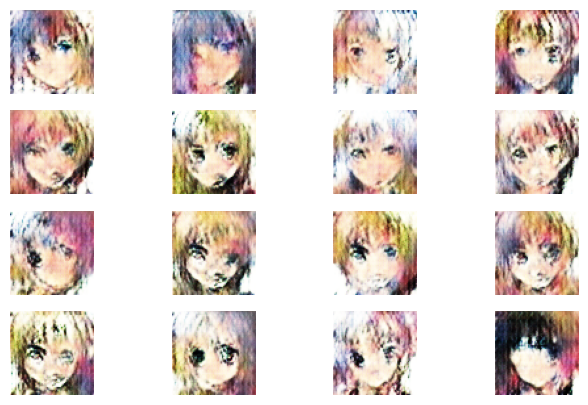

In [40]:
plt.figure(figsize=(8,5))
for i in range(16):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(gen_img1[i].numpy().astype("uint8"))
  plt.axis('off')

plt.show()

NEEDS MORE EPOCHS, BUT TRAINING TIME TOO HIGH

QUESTION-2

In [41]:
import os
import time
import random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
!git clone https://github.com/ultralytics/yolov5
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 16530, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 16530 (delta 1), reused 5 (delta 0), pack-reused 16522
Receiving objects: 100% (16530/16530), 15.00 MiB | 8.58 MiB/s, done.
Resolving deltas: 100% (11360/11360), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


In [43]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])

df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

image_id        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [44]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/car-object-detection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_2520


(380, 676, 3)

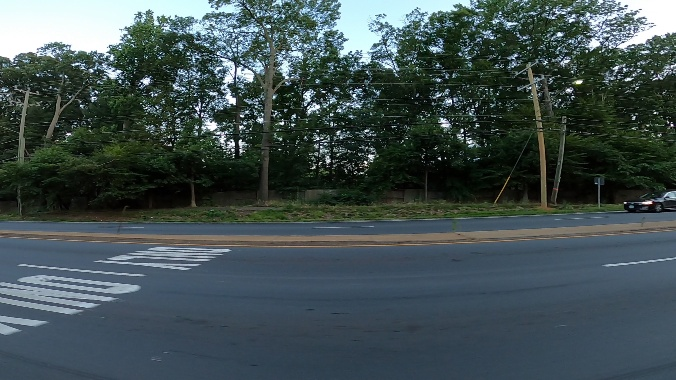

In [45]:
image = random.choice(index)
Image(filename=f'/content/car-object-detection/data/training_images/{image}.jpg',width=600)

In [46]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/car-object-detection/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [47]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/car-object-detection/data/testing_images

detect: weights=['yolov5/yolov5s.pt'], source=/content/car-object-detection/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-297-gd07d0cf6 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

100% 14.1M/14.1M [00:00<00:00, 315MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /content/car-object-detection/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 50.3ms
image 2/175 /content/car-object-detection/data/testing

In [48]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("runs/detect/py"):
    predicted_files.extend(filenames)

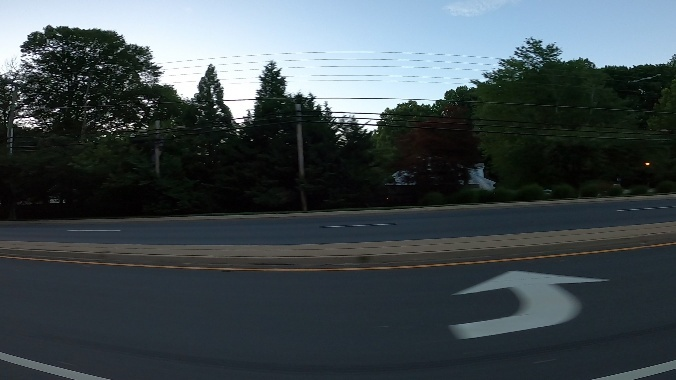

In [55]:
Image(filename='/content/yolov5/runs/detect/exp/vid_5_29080.jpg')

No Car Detected

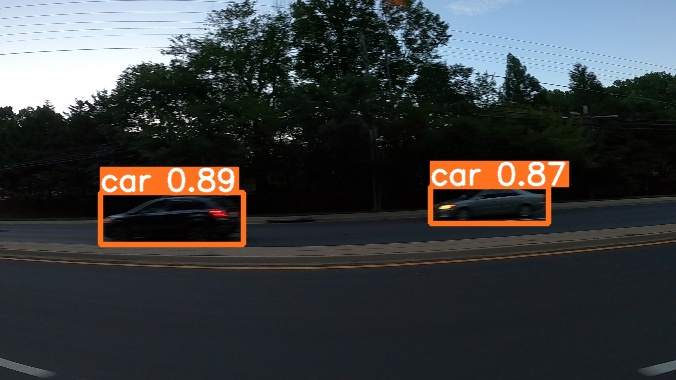

In [57]:
Image(filename='/content/yolov5/runs/detect/exp/vid_5_29000.jpg')

Multiple Cars Detected


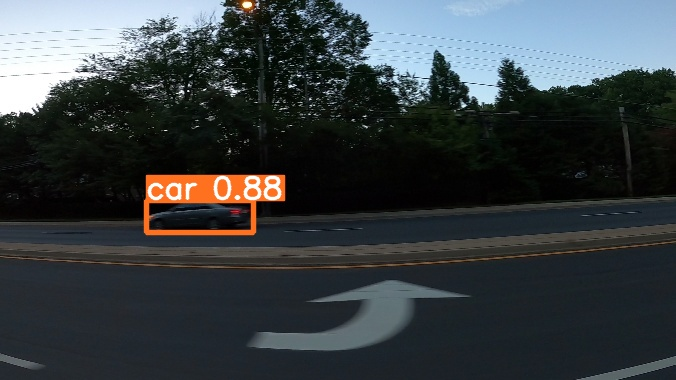

In [61]:
Image(filename='/content/yolov5/runs/detect/exp/vid_5_29020.jpg')

Single Object Detected

QUESTION-3

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

SIZE = 160
color_img = []
path = '/content/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '6000.jpg':
        break
    else:
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '/content/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else:
        img = cv2.imread(path + '/'+i,1)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 84%|████████▍ | 6000/7129 [00:05<00:01, 1051.59it/s]


In [13]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Colour Image', color = 'red', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)

    plt.show()

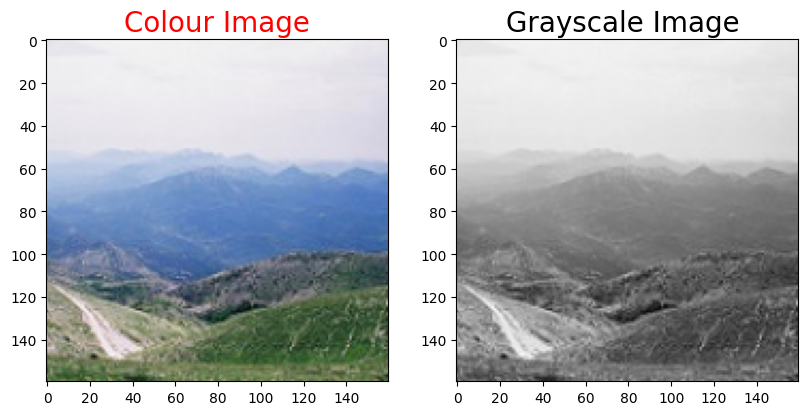

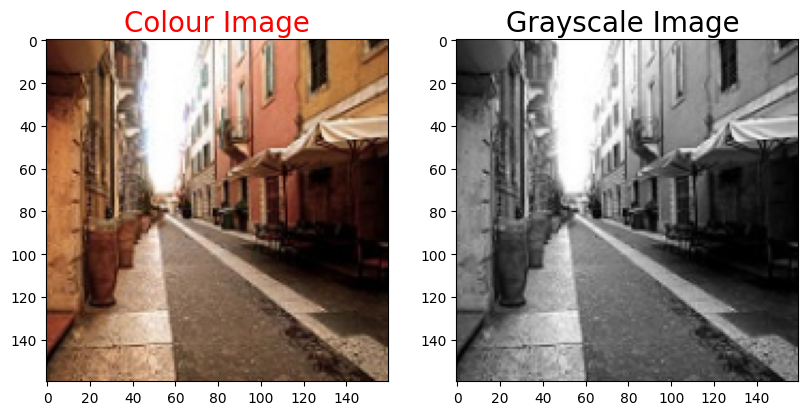

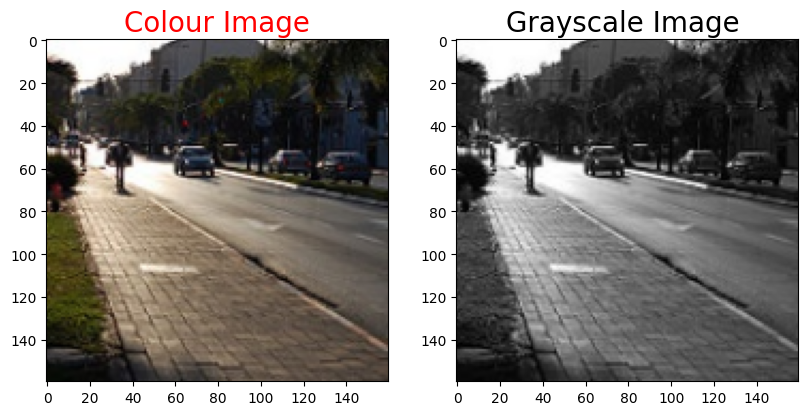

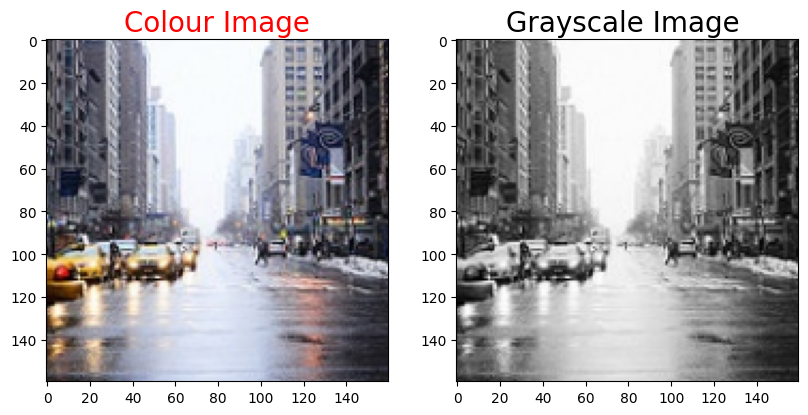

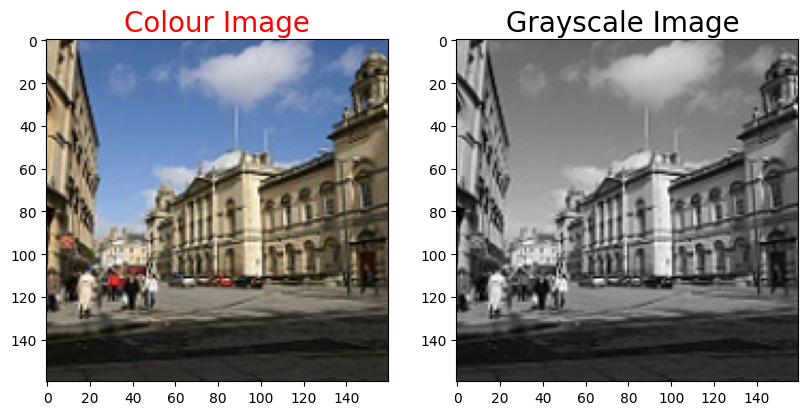

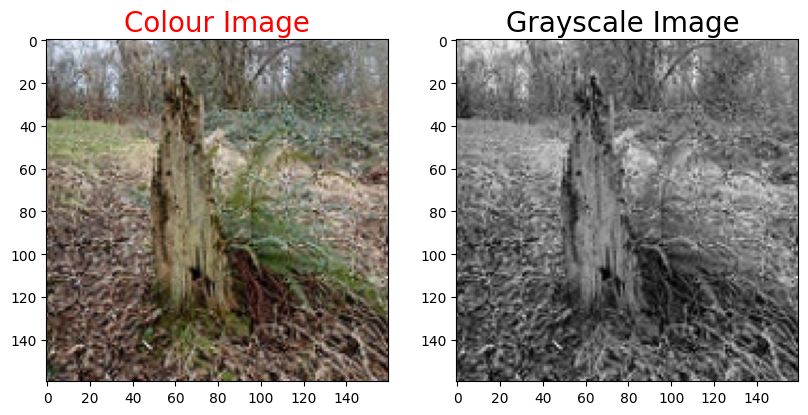

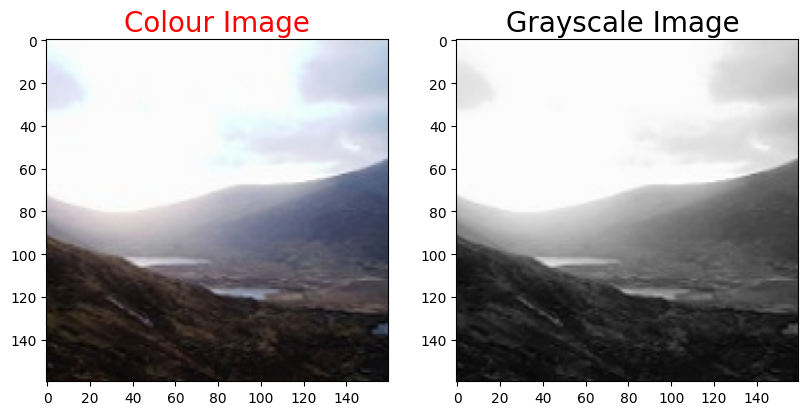

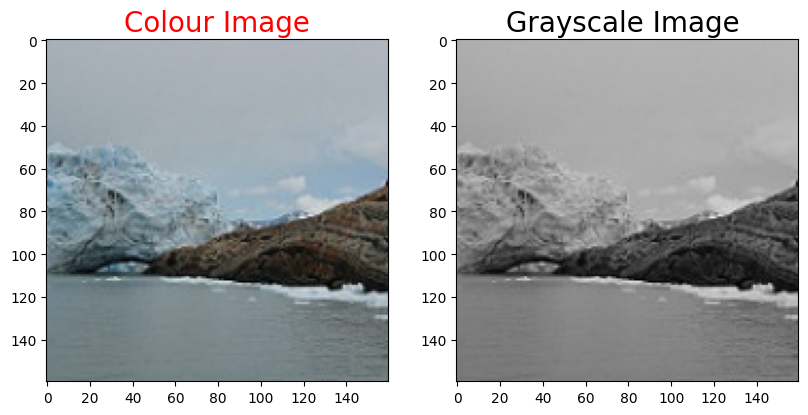

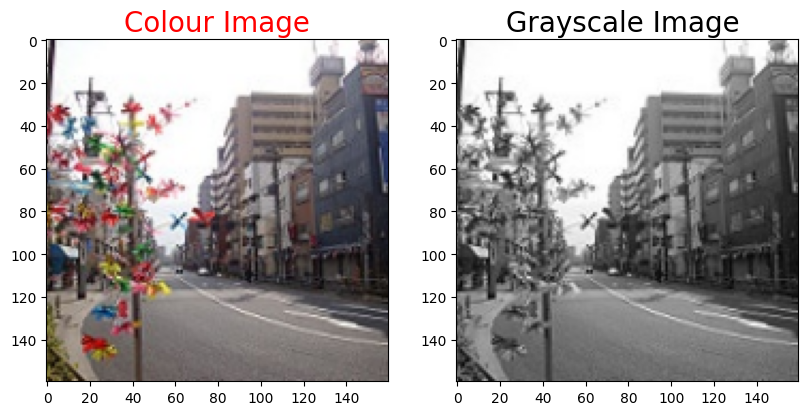

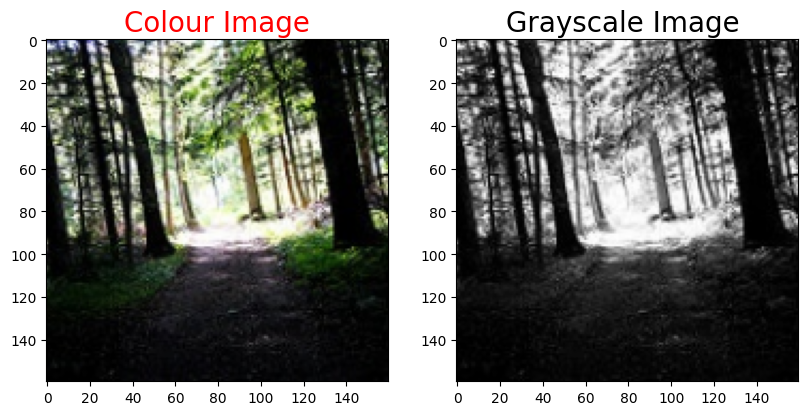

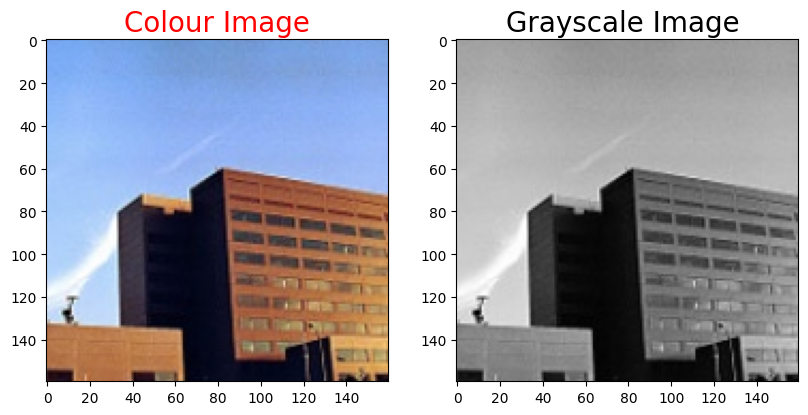

In [14]:
for i in range(20,31):
     plot_images(color_img[i],gray_img[i])

In [15]:
train_gray_img = gray_img[:5500]
train_color_img = color_img[:5500]

test_gray_img = gray_img[5500:]
test_color_img = color_img[5500:]

train_g = np.reshape(train_gray_img,(len(train_gray_img),SIZE,SIZE,3))
train_c = np.reshape(train_color_img, (len(train_color_img),SIZE,SIZE,3))
print('Shape of Coloured Trained Images:',train_c.shape)


test_gray_img = np.reshape(test_gray_img,(len(test_gray_img),SIZE,SIZE,3))
test_color_img = np.reshape(test_color_img, (len(test_color_img),SIZE,SIZE,3))
print('Shape of Coloured Test Images',test_color_img.shape)

Shape of Coloured Trained Images: (5500, 160, 160, 3)
Shape of Coloured Test Images (500, 160, 160, 3)


In [16]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [17]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)

    d5 = down(512,(3,3),True)(d4)

    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [8]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 80, 80, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 40, 40, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 20, 20, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',metrics = ['acc'])
model.fit(train_g[:1000], train_c[:1000], epochs = 50,batch_size = 50,verbose = 1)

Epoch 1/50
20/20 [==============================] - 20s 241ms/step - loss: 0.1749 - acc: 0.3925
Epoch 2/50
20/20 [==============================] - 5s 242ms/step - loss: 0.0892 - acc: 0.3662
Epoch 3/50
20/20 [==============================] - 5s 243ms/step - loss: 0.0807 - acc: 0.4015
Epoch 4/50
20/20 [==============================] - 5s 246ms/step - loss: 0.0759 - acc: 0.4358
Epoch 5/50
20/20 [==============================] - 5s 244ms/step - loss: 0.0718 - acc: 0.4547
Epoch 6/50
20/20 [==============================] - 5s 259ms/step - loss: 0.0691 - acc: 0.4566
Epoch 7/50
20/20 [==============================] - 5s 250ms/step - loss: 0.0660 - acc: 0.4725
Epoch 8/50
20/20 [==============================] - 5s 256ms/step - loss: 0.0642 - acc: 0.4679
Epoch 9/50
20/20 [==============================] - 5s 254ms/step - loss: 0.0639 - acc: 0.4674
Epoch 10/50
20/20 [==============================] - 5s 255ms/step - loss: 0.0615 - acc: 0.4714
Epoch 11/50
20/20 [=============================

In [10]:
model.evaluate(test_gray_img,test_color_img)

16/16 [==============================] - 6s 196ms/step - loss: 0.0555 - acc: 0.5154


[0.05552799999713898, 0.5154067873954773]

1/1 [==============================] - 0s 49ms/step


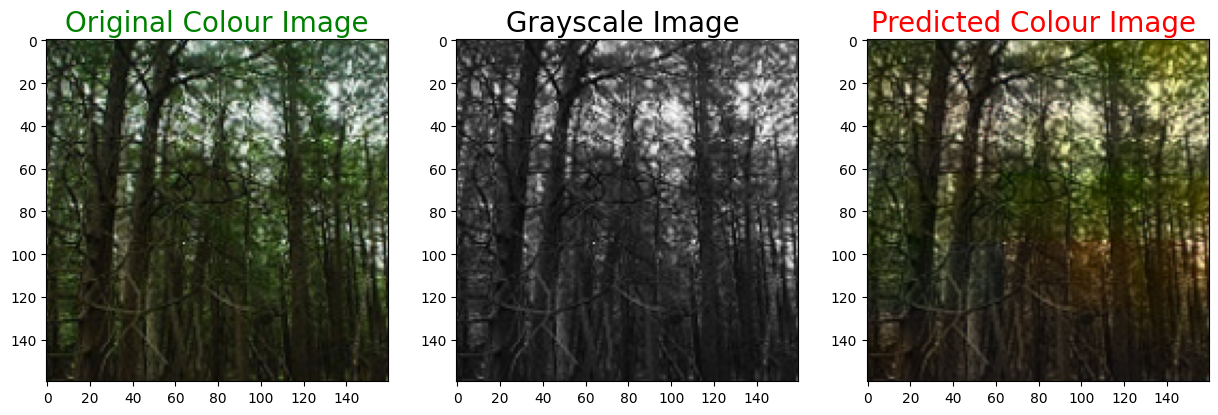

1/1 [==============================] - 0s 84ms/step


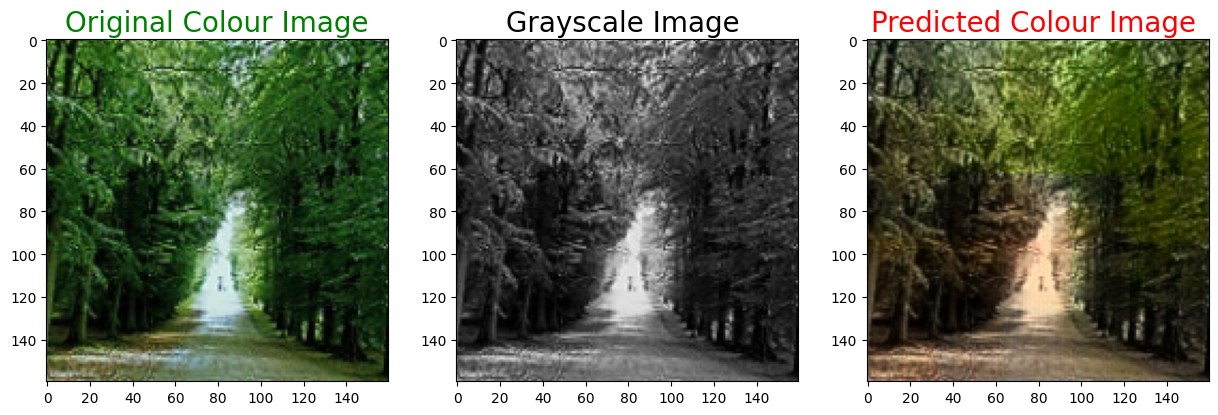

1/1 [==============================] - 0s 89ms/step


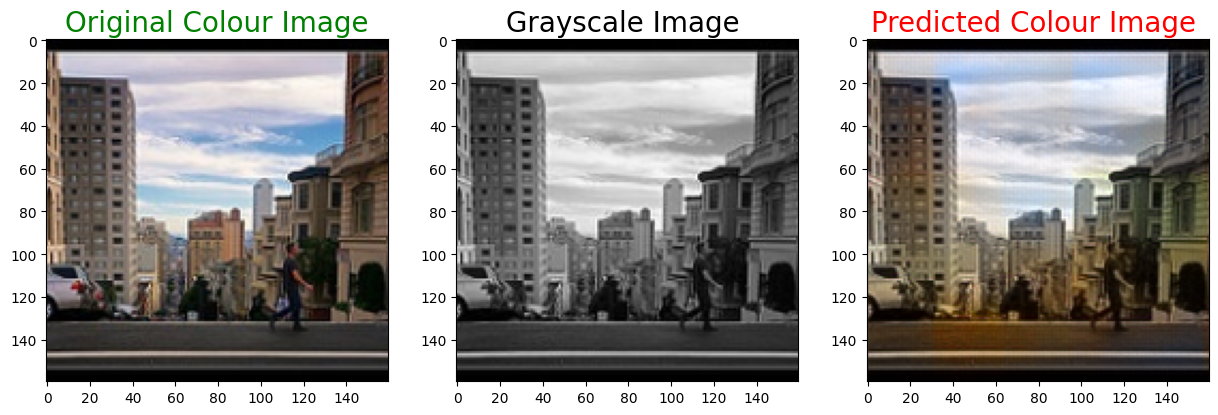

1/1 [==============================] - 0s 41ms/step


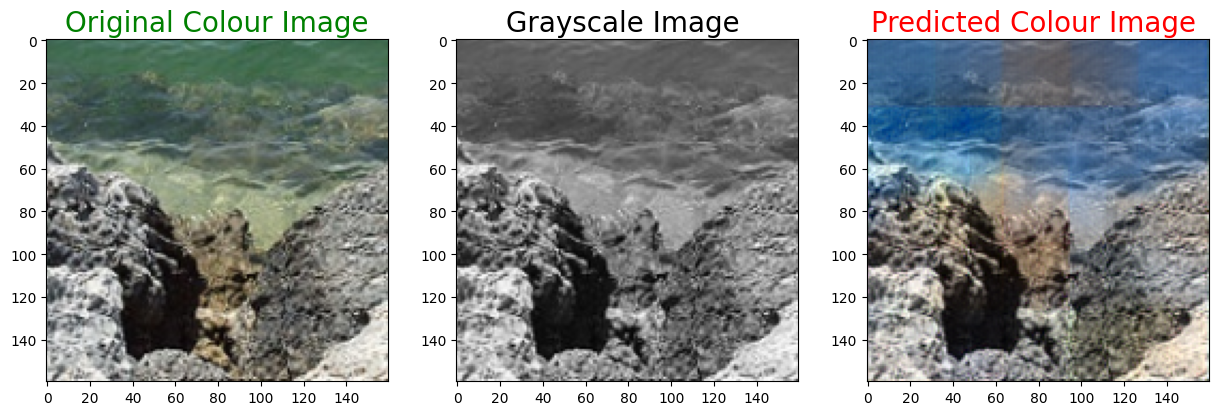

1/1 [==============================] - 0s 27ms/step


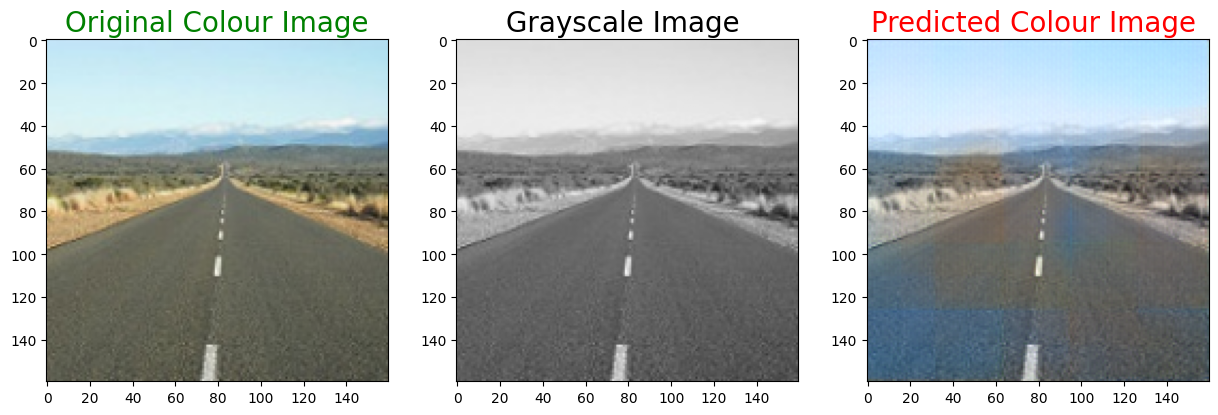

1/1 [==============================] - 0s 27ms/step


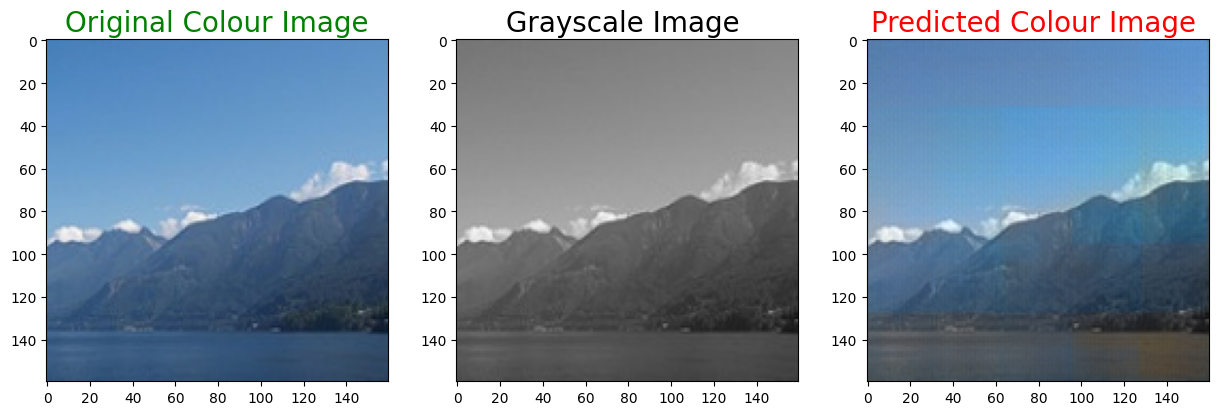

1/1 [==============================] - 0s 26ms/step


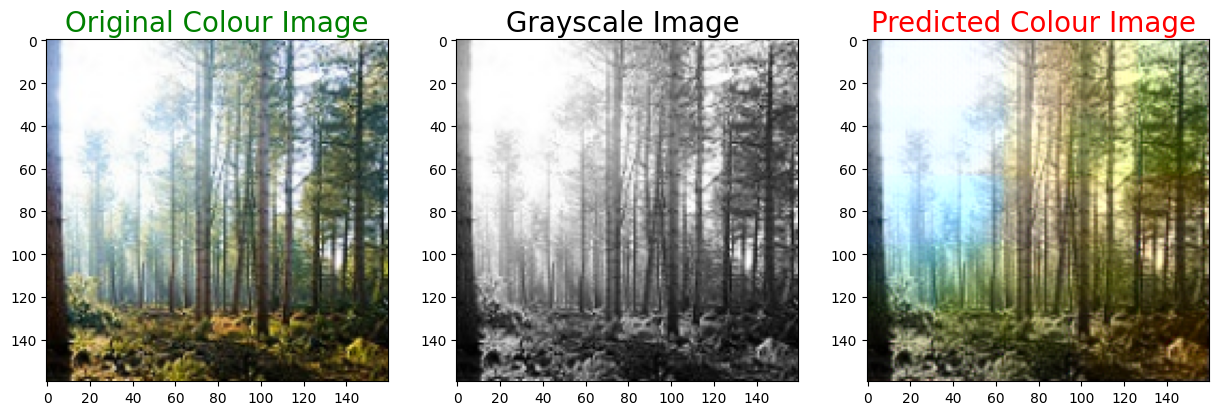

1/1 [==============================] - 0s 28ms/step


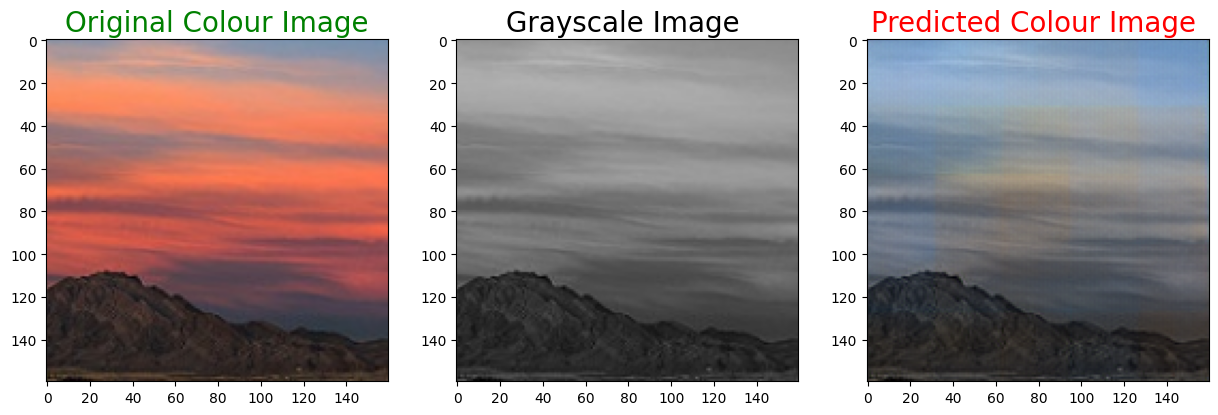

In [12]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Original Colour Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Colour Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_img[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_img[i],test_gray_img[i],predicted)

In [2]:
!pip install watermark
%load_ext watermark
%watermark -a "Sri Hari Sai P - 21BAI1143" -u -d -v -m

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.8 MB/s eta 0:00:00
Author: Sri Hari Sai P - 21BAI1143

Last updated: 2024-04-12

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.58+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

